  # AYGAZ GÖRÜNTÜ İŞLEME BOOTCAMP                                                       

# PROJENİN AMACI ;

    Bu projenin temel amacı, Convolutional Neural Network (CNN) tabanlı bir derin öğrenme modeli geliştirerek geniş bir veri kümesi üzerinde yer alan çeşitli hayvan türlerini sınıflandırmaktır. Proje kapsamında, CNN algoritmalarının etkili bir şekilde eğitilmesi ve test edilmesi hedeflenmektedir. Bu süreçte, seçilen veri kümesindeki hayvan görselleri kullanılarak modelin doğruluğu ve performansı analiz edilecektir. Geliştirilecek model, görüntü işleme ve sınıflandırma alanındaki teknikleri uygulamalı olarak deneyimlemek ve bu alandaki bilgi birikimini artırmak amacıyla tasarlanmıştır.

# KULLANILAN KÜTÜPHANELER ve FONKSİYONLARI ;

* **os: Dosya ve klasör işlemleri için kullanıldı.**
* **cv2: Görsellerle ilgili işleme yüklenmiştir.**
* **shutil: Dosya kopyalama işlemlerinde kullanıldı**
* **torch, sklearn: Model eğitimi ve değerlendirme aşamalarında kullanılmak üzere çağrılmıştır.**
* **matplotlib: Veri görselleştirme için kullanılıyor.**
* **numpy: Sayısal hesaplamalar ve veri manipülasyonu için.**

In [387]:
import os
import cv2
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

# Veri Yolunun Tanımlanması ;

* **path : Kullandığımız Dataset'in konumunu belirtir**
* **subfolder_path : Görsellerin bulunduğu alt klasörü belirler.**
* **output_folder : Değiştirilmiş fotoğrafların kopyalanacağı çıkış klasörüdür.**
* **selected_animals : Dataset'in içindeki seçili olan alt klasörleri belirtir.**

In [388]:
path = "/kaggle/input/animals-with-attributes-2"
subfolder_path = os.path.join(path, "Animals_with_Attributes2/JPEGImages")
output_folder = "/kaggle/working/selected_animals"
os.makedirs(output_folder, exist_ok=True)

selected_animals = ["collie", "dolphin", "elephant", "fox", 
                    "moose", "rabbit", "sheep", "squirrel", 
                    "giant+panda", "polar+bear"]

# Görsellerin kopyalanma ve Sınıflandırma süreci ;

* **animal : Seçili olan hayvan sınıflarını bu değişkenin içine atanır ve işlemleri bu değişken üzerinden yapılır.**
* **animal_folder : Gerekli işlemlerden geçen sınıfların klasör yolunu oluşturmak.**
* **destination : Seçilen hayvan sınıfına ait bir klasör oluşturur.**
* **image_files : Dataset'in içindeki seçili olan sınıfların ilk 650 verisini listeler.**
* **source_file : Listelenen klasörleri kaynak klasörden hedef klasöre kopyalamak.**

**Bu alanda yazdığımız kod, Datasetimizde ki veri kümesindeki belirli hayvan sınıflarına ait görselleri, eğitim ve test veri seti oluşturma amacıyla organize etmektedir. İşlem sırasında, her bir sınıf için maksimum 650 adet görsel kopyalanır ve ayrı bir klasöre yerleştirilir. Kod, temel olarak şu işlevleri yerine getirir.**

In [389]:
for animal in selected_animals:
    animal_folder = os.path.join(subfolder_path, animal.replace(" ", "_"))
    if os.path.exists(animal_folder):
        destination = os.path.join(output_folder, animal.replace(" ", "_"))
        os.makedirs(destination, exist_ok=True)
        
        image_files = os.listdir(animal_folder)[:650]
        for file_name in image_files:
            source_file = os.path.join(animal_folder, file_name)
            if os.path.isfile(source_file):
                shutil.copy(source_file, destination)
        print(f"{animal} sınıfından 650 görsel kopyalandı.")
    else:
        print(f"Klasör bulunamadı: {animal_folder}")

collie sınıfından 650 görsel kopyalandı.
dolphin sınıfından 650 görsel kopyalandı.
elephant sınıfından 650 görsel kopyalandı.
fox sınıfından 650 görsel kopyalandı.
moose sınıfından 650 görsel kopyalandı.
rabbit sınıfından 650 görsel kopyalandı.
sheep sınıfından 650 görsel kopyalandı.
squirrel sınıfından 650 görsel kopyalandı.
giant+panda sınıfından 650 görsel kopyalandı.
polar+bear sınıfından 650 görsel kopyalandı.


# Veriyi Yükleme ve Görselleri İşleme ;

* **load_dataset : Belirli bir dizinde bulunan görselleri okur, ön işler ve etiketler ile birlikte bir veri kümesi oluşturur.**
* **image_dir : Görsellerimizin bulunduğu ana dizindir.**
* **categories : Modelin öğreneceği sınıf adlarını belirtir.**
* **label_map : Her sınıfa bir id tanımlar.**
* **category_path : Her sınıfa ait alt klasörünün oluşturuluyor ve bunlar bu değişkenimizde tutuluyor ve bu sayede gerekli sınıfın olup olmadığını kontrol edebiliyoruz.**
* **image_files : Görselleri almamıza yarar burada ve random fonksiyonunu kullanarak karıştırmamıza yarar.**
* **image_name : image_files'dan ilk 650 görüntüyü alıp bundan sonraki adımları bu değişken üzerinde gerçekleşir.**
* **image_path : Görsellerin dosya yolunu oluşturur.**
* **image : Bu değişkene Opencv ile okunmuş veriler aktarılır.**
* **images : İşlenmiş görseller yani boyutu değiştirildikten sonra bu değişkenimize atanır.**
* **labels : İşlenmiş görsellerin etiketleri bu değişkenimizin içinde tutulur.**

**Bu alanda yaptığımız işlem tam olarak, belirtilen bir dizinden görselleri yükler, her bir görseli uygun boyuta getirir, etiketler ile eşleştirir ve bunları bir NumPy dizisine dönüştürerek eğitim için hazır hale getirir. Ayrıca, her kategoriye ait görsellerin karıştırılması ve sadece ilk 650 görselin alınması gibi işlemlerle, modelin genel doğruluğunu artırmaya yönelik adımlar atılır.**

In [391]:
def load_dataset(image_dir):
    images = []
    labels = []
    
    categories = ["collie", "dolphin", "elephant", "fox", 
                  "moose", "rabbit", "sheep", "squirrel", 
                  "giant+panda", "polar+bear"]
    label_map = {category: idx for idx, category in enumerate(categories)}

    for category in categories:
        category_path = os.path.join(image_dir, category)
        if not os.path.exists(category_path):
            print(f"Klasör eksik: {category}")
            continue

        image_files = os.listdir(category_path)
        random.shuffle(image_files)

        for image_name in image_files[:650]:
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (64, 64))
                images.append(image)
                labels.append(label_map[category])
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

image_dir = "/kaggle/working/selected_animals"
images, labels = load_dataset(image_dir)

# Eğitim ve Test Verilerini Ayırma ve Veri Dönüşümleri ;

# Eğitim ve Test Verilerini Ayırma ;

* **train_test_split(): Bu fonksiyon, verileri rastgele şekilde eğitim ve test setlerine böler.**
* **images: Görsellerin bulunduğu NumPy dizisi.**
* **labels: Görsellere ait etiketlerin bulunduğu NumPy dizisi.**
* **test_size=0.2: Bu parametre, verilerin %20'inin test seti olarak ayrılmasını belirtir. Yani, verilerin geri kalan %80'i eğitim seti olarak kullanılacaktır.**
* **random_state=42: Bu parametre, rastgelelikğin kontrol edilmesini sağlar. Aynı random_state değeriyle çalışıldığında, her seferinde aynı sonuçları alırsınız. Bu, modelin tekrar edilebilirliğini sağlar.**

# Veri Dönüşümleri(Arttırma) ;

* **transforms.Compose : Birden fazla işlemi ard arda uygulamak için kullanılır.**
* **ToPILImage : NumPy dizisi veya Tensor'dan bir PIL görüntüsüne dönüştürür.**
* **RandomHorizontalFlip : Görsellerin rastgele şekilde yatayda çevrilmesini sağlar.**
* **RandomRotation : Görsellerin rastgele olarak 10 dereceye kadar döndürülmesini sağlar.**
* **ToTensor : Görseli bir PyTorch tensörüne dönüştürür.**
* **Normalize : Bu dönüşüm, görsellerin normalizasyonunu yapar.**


**Buradaki yazdığımız kod parçası, model eğitimi için verilerin eğitim ve test setlerine ayrılmasını sağlar. Aynı zamanda, eğitim sırasında veriye uygulanacak dönüşümleri de tanımlar. Veri dönüşümleri, modelin daha genelleştirilmiş bir şekilde öğrenmesini ve aşırı uyum sağlamamasını sağlamak için kullanılır.**

In [392]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# CustomDataset Sınıfı: Veri Kümesi Özelleştirme ;

* **CustomDataset : Bu sınıf, görseller ve etiketlerle özelleştirilmiş bir veri kümesi oluşturur.**
* **Dataset: PyTorch’un veri kümesi sınıfıdır ve görsel, metin, vb. verilerin nasıl yüklenip işlendiğini tanımlar.**
* **init : Bu metod, images, labels ve isteğe bağlı olarak transform parametrelerini sınıfın örneği için saklar.**
* **len : self.images dizisinin uzunluğunu döndürür, yani toplamda kaç görsel olduğunu belirtir.**
* **getitem : Bu metod, index numarası ile veri kümesinden bir görsel ve etiket alır. Metod, işlenmiş görseli ve etiketini döndürür. Bu, modelin eğitiminde kullanılacak veriyi temsil eder.**

In [393]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Eğitim ve Test Veri Setlerinin Oluşturulması ;
* **train_images, train_labels : Eğitim için kullanılan görseller ve etiketlerdir. Bu veri, eğitim sırasında modelin öğrenmesi için kullanılacaktır.**
* **test_images, test_labels : Test verisi, modelin eğitildikten sonra doğruluğunu değerlendirebilmek için kullanılır.**
* **transform : Görsellere uygulanan dönüşümleri içeren bir parametredir**

**train_images ve train_labels ile eğitim veri seti (train_dataset), test_images ve test_labels ile de test veri seti (test_dataset) oluşturulur. Bu veri setleri, daha sonra her bir görüntüyü ve etiketini yükleyebilmek için DataLoader ile kullanılacak.**

# Veri Yükleyicilerinin (DataLoader) Oluşturulması ;

* **train_dataset : Eğitim veri kümesi, önceden CustomDataset sınıfıyla oluşturulmuş ve dönüşümlere tabi tutulmuş eğitim verilerini içerir.**
* **batch_size : Batch size (mini-batch boyutu), her seferinde modelin eğitim için alacağı örnek sayısını belirtir.**
* **shuffle : Bu parametre, veri setinin her epoch (eğitim turu) başında karıştırılmasını sağlar.**

**Eğitim verisi için train_loader, test verisi için ise test_loader nesneleri oluşturulur.**

In [394]:
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN Modeli

# Kullandığım Değişkenler ;
* **in_channels : Giriş kanal sayısıdır. Renkli görsellerde bu değer 3’tür (RGB).**
* **out_channels : Çıkış kanal sayısıdır ve bu, her konvolüsyonel katmanda öğrenilecek özellik haritasının (feature map) sayısını belirler.**
* **kernel_size : Konvolüsyonel çekirdek boyutudur.**
* **stride : Konvolüsyonun hareket adımıdır. Yani, her adımda pencereler ne kadar kayacak.**
* **padding : Görselin kenarlarına eklenen boşluktur, böylece konvolüsyonel işlem sırasında boyut kaybı önlenebilir.**
* **MaxPool2d : Max pooling, görselin boyutunu küçültmek için kullanılan bir işlemdir.**
* **fc_input_size : Bu, son konvolüsyonel katmandan sonra özelliklerin düzleştirilen boyutudur.**
* **Dropout : Dropout, aşırı uyum (overfitting) önlemek için kullanılan bir tekniktir.**
* **forward : Bu metod, modelin ileri besleme (forward pass) fonksiyonudur. Girdi verisi, modelin katmanlarından geçer.**
* **relu : Bu, giriş değerini pozitif olduğu sürece olduğu gibi bırakan, negatif olduğu durumlarda ise sıfıra indirgeyen bir fonksiyondur.**
* **pool : Daha küçük boyutlara indirgemek amacıyla kullanılan bir işlem türüdür.**
* **num_classes : Modelin kaç sınıf olduğunu belirtiyor.**
* **cnn_model = CNNModel(num_classes) : Bu satır, CNN modelini oluşturur ve 10 sınıf için yapılandırılmıştır.**
* **criterion : Modelin kayıp fonksiyonu belirlenir.**
* **optimizer_cnn : Modelin parametrelerini optimize etmek için kullanılır ve en uygun optimizer seçilir.**


**Bu kod parçası, Convolutional Neural Network (CNN) modelinin yapılandırılmasını ve eğitim için gerekli parametrelerin ayarlanmasını içermektedir. Model, konvolüsyonel katmanlar, max pooling, tam bağlantılı katmanlar ve dropout işlemlerini içerir. Ayrıca, eğitim sırasında kullanılan kayıp fonksiyonu Focal Loss ve optimizasyon için Adam optimizer'ı seçilmiştir.**

In [395]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc_input_size = (64 // 8) * (64 // 8) * 128
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = 10 
cnn_model = CNNModel(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0005)

# Modelin Eğitim Süreci ; 

* **model : Eğitim sırasında kullanılacak olan modeldir.**
* **loader : Eğitim verisini sağlayan DataLoader nesnesidir.**
* **criterion : Kayıp fonksiyonudur (loss function). Modelin tahminleri ile gerçek etiketler arasındaki farkı hesaplar.**
* **optimizer: Optimizasyon algoritmasıdır.**
* **epochs : Bu, eğitim için kullanılacak epoch sayısıdır.**
* **running_loss : Her epoch başında, o epoch için toplam kaybı tutan bir değişkendir.**
* **optimizer.zero_grad : Bu komut, her iterasyondan önce optimizer'ın gradyanları sıfırlamasını sağlar.**
* **outputs : Bu, modelin ileri geçiş (forward pass) işlemidir.**
* **loss : Bu, kayıp fonksiyonunu çağırıyoruz.**
* **loss.backward : Bu, kaybın geri yayılımını başlatır. Yani, modelin her parametresinin, kaybı minimize etmek için ne kadar değiştirilmesi gerektiğini hesaplar.**
* **optimizer.step : Bu komut, modelin parametrelerini günceller.**

**Bu kodumuzda, CNN modelini eğitmek için kullanılan bir eğitim fonksiyonu (train_model) tanımlar. Eğitim sürecini yürütürken modelin parametrelerini optimize eder, kayıp fonksiyonunu minimize etmeye çalışır ve her bir epoch (dönem) sonrasında kayıp değerini yazdırır.**

In [396]:
def train_model(model, loader, criterion, optimizer, epochs=30):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in loader:
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(loader)}')

# Model'in Değerlendirilmesi ;

* **model.eval(): Modelin değerlendirme moduna geçmesini sağlar**
* **all_labels ve all_preds : Test verisi üzerinde doğru etiketler (labels) ve modelin tahmin ettiği etiketler (predictions) Bu listeler, tüm test verisi için toplu sonuçları saklamak amacıyla kullanılacak.**
* **with torch.no_grad : Bu blok, değerlendirme aşamasında gradyan hesaplanmasını devre dışı bırakır.**
* **_, preds = torch.max(outputs, 1) : torch.max fonksiyonu, her örnek için en yüksek olasılığı veren sınıfı bulur.**
* **preds: Modelin her bir görsel için tahmin ettiği sınıflardır.**
* **classification_report : Scikit-learn'ün classification_report fonksiyonu, sınıflandırma sonuçlarını özetleyen bir rapor üretir.**
* **train_model : train_model fonksiyonunu çağırarak modelin eğitim sürecini başlatır.**
* **evaluate_model : Bu satır, evaluate_model fonksiyonunu çağırarak eğitim tamamlandıktan sonra test verisi üzerinde modelin başarı performansını değerlendirir**

**Bu fonksiyon, modelin test verisi üzerindeki değerlendirmesini yapar. Test verileri üzerinden yapılan tahminlerin doğruluğu, precision, recall, F1-score gibi metrikler kullanılarak ölçülür. Bu metrikler, modelin ne kadar iyi çalıştığını ve hangi sınıflarda güçlü ya da zayıf olduğunu anlamamıza yardımcı olur.**

In [397]:
def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    print(classification_report(np.array(all_labels), np.array(all_preds)))

train_model(cnn_model, train_loader, criterion, optimizer_cnn, epochs=30)

evaluate_model(cnn_model, test_loader)

Epoch [1/30], Loss: 1.7522353935826775
Epoch [2/30], Loss: 1.3731751997778021
Epoch [3/30], Loss: 1.207822297614045
Epoch [4/30], Loss: 1.0482821113492813
Epoch [5/30], Loss: 0.9404265741629103
Epoch [6/30], Loss: 0.8363264086056341
Epoch [7/30], Loss: 0.7770260234186255
Epoch [8/30], Loss: 0.7007829695025836
Epoch [9/30], Loss: 0.6225804656378331
Epoch [10/30], Loss: 0.5664643367375333
Epoch [11/30], Loss: 0.4978225829959647
Epoch [12/30], Loss: 0.4549109420619128
Epoch [13/30], Loss: 0.4003756979674649
Epoch [14/30], Loss: 0.35256537772212293
Epoch [15/30], Loss: 0.3234249966367622
Epoch [16/30], Loss: 0.2813224673865397
Epoch [17/30], Loss: 0.2501305250302414
Epoch [18/30], Loss: 0.23039478918343234
Epoch [19/30], Loss: 0.19983620228577245
Epoch [20/30], Loss: 0.1786603434297022
Epoch [21/30], Loss: 0.1582648059456078
Epoch [22/30], Loss: 0.1554685043502439
Epoch [23/30], Loss: 0.15673539962368144
Epoch [24/30], Loss: 0.14123691285908954
Epoch [25/30], Loss: 0.1245987615176688
Epoch

# Test Doğruluğunu Hesaplama ;

* **all_labels : Gerçek etiketleri tutacak bir liste.**
* **all_preds : Modelin tahmin ettiği etiketleri tutacak bir liste.**
* **with torch.no_grad : Bu, gradyan hesaplanmasını devre dışı bırakır, çünkü test aşamasında modelin parametreleri güncellenmez.**
* **accuracy_score : Bu fonksiyon, Scikit-learn kütüphanesinden gelen bir fonksiyondur ve doğruluğu hesaplar.**
* **return accuracy : Hesaplanan doğruluk değeri fonksiyonun çıktısı olarak döndürülür.**
* **cnn_accuracy : Bu komut accuracy_score fonksiyonunu çağırarak CNN modelinin test verisi üzerindeki doğruluğunu hesaplar.**
* **plt. İşlemleri : Görselleştirmek için kullanılır.**

**Burada ki amacımız, modelin test doğruluğunu hesaplamak ve bunu grafiksel olarak görselleştirmek. İlk olarak, modelin doğruluğu hesaplanır ve daha sonra bu doğruluk yüzde cinsinden yazdırılır. Ardından, model doğruluğu bar grafiği ile görselleştirilir.**

CNN Model Doğruluğu: 72.38%


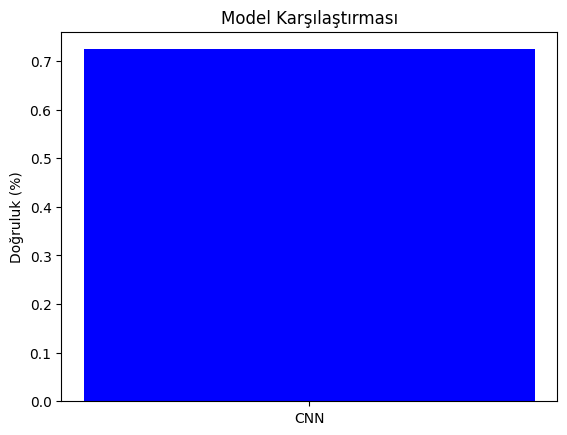

In [398]:
def calculate_accuracy(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    accuracy = accuracy_score(np.array(all_labels), np.array(all_preds))
    return accuracy

cnn_accuracy = calculate_accuracy(cnn_model, test_loader)
print(f"CNN Model Doğruluğu: {cnn_accuracy * 100:.2f}%")

plt.bar(['CNN'], [cnn_accuracy], color=['blue'])
plt.title('Model Karşılaştırması')
plt.ylabel('Doğruluk (%)')
plt.show()

# Görselleri Manipüle Etmek ;

**Burada yaptığımız işlem, görüntüleri farklı manipülasyonlarla çeşitlendirerek bir veri artırma (data augmentation) stratejisi uygular. Böylece model, daha geniş bir veri çeşitliliğiyle eğitilir ve gerçek dünyadaki karmaşık durumlara (bulanıklık, düşük ışık, dönme, vb.) karşı daha dayanıklı hale gelir.**

**Manipülasyonların Eğitime Dahil Edilmemesi : Eğitim sırasında manipülasyonların uygulanmaması, modelin bu tür verileri tanımakta zorlanmasına yol açar.**

**Model Mimarisi ve Kapasite Eksikliği : Mevcut model, manipüle edilmiş verilerdeki karmaşıklığı yakalamak için yeterince derin olmayabilir daha da gelişmesi gerekiyor olabilir.**

**Eğitim verisi çeşitlendirilerek modelin genelleme yeteneği geliştirilebilir.**

In [399]:
def manipulate_image(image):
    
    if random.random() > 0.5:
        image = cv2.flip(image, 1) 
    
    if random.random() > 0.5:
        angle = random.randint(-15, 15)
        rows, cols = image.shape[:2]
        M = cv2.getRotationMatrix2D((cols // 2, rows // 2), angle, 1)
        image = cv2.warpAffine(image, M, (cols, rows))
    
    if random.random() > 0.5:
        image = cv2.GaussianBlur(image, (5, 5), 0)

    if random.random() > 0.5:
        alpha = random.uniform(0.8, 1.2)
        beta = random.randint(-20, 20)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    if random.random() > 0.5:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[..., 0] = (hsv[..., 0] + random.randint(-10, 10)) % 180
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return image

def get_manipulated_images(test_images, output_dir="manipulated_images"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    manipulated_images = []
    
    for i, image in enumerate(test_images):
        manipulated_image = manipulate_image(image)
        
        save_path = os.path.join(output_dir, f"manipulated_image_{i+1}.png")
        
        cv2.imwrite(save_path, manipulated_image)
        
        manipulated_images.append(manipulated_image)
    
    print(f"Manipüle edilmiş resimler '{output_dir}' klasörüne kaydedildi.")
    
    return manipulated_images

manipulated_test_images = get_manipulated_images(test_images, output_dir="manipulated_images")

def calculate_accuracy_for_manipulated_images(model, manipulated_images, test_labels):
    model.eval()
    all_labels = test_labels
    all_preds = []

    with torch.no_grad():
        for image in manipulated_images:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (64, 64))
            image = transform(image).unsqueeze(0)

            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            
            all_preds.append(preds.item())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

manipulated_accuracy = calculate_accuracy_for_manipulated_images(cnn_model, manipulated_test_images, test_labels)
print(f"Manipüle Edilmiş Test Verileri Doğruluğu: {manipulated_accuracy * 100:.2f}%")

Manipüle edilmiş resimler 'manipulated_images' klasörüne kaydedildi.
Manipüle Edilmiş Test Verileri Doğruluğu: 25.00%


# Renk Sabitliği ;

**Bu kod, görüntülerin renk sabitliğini artırmak için Gray World Algoritması uygulanmasını içerir. Bu algoritma, özellikle farklı aydınlatma koşullarında modelin doğruluğunu nasıl değişim gösterdiğini gözlemlemeyi hedefler**

**Eğitim sırasında Gray World algoritması veya benzer renk sabitliği teknikleri uygularsak burada yaptığımız işlemde daha çok başarı alabiliriz.**

**Retinex Theory veya White Patch Algorithm. Bu algoritmalar daha karmaşık aydınlatma farklılıklarını düzeltebilir. Bu da oranın artmasını sağlayabilir.**

**Görüntü sınıflandırma problemlerinde renk sabitliği, model performansını artırmak için etkili bir tekniktir. Bu kodda kullanılan Gray World algoritması, manipüle edilmiş test görüntülerine uygulanarak modelin doğruluğu ölçülmüştür. Elde edilen sonuçlar, renk sabitliğinin manipüle edilmiş verilere göre beklenen doğruluğun altında kalmıştır belirli denemelerle seviyesi %40'lara çıkmıştır.**

In [400]:
def apply_gray_world(image):
    image = image.astype(np.float32)
    mean_r = np.mean(image[..., 2])
    mean_g = np.mean(image[..., 1])
    mean_b = np.mean(image[..., 0])
    scale_r = mean_g / mean_r
    scale_b = mean_g / mean_b
    image[..., 2] *= scale_r
    image[..., 0] *= scale_b

    image = np.clip(image, 0, 255).astype(np.uint8)
    return image

def get_wb_images(images, output_dir="wb_images"):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    wb_images = []

    for i, image in enumerate(images):
        wb_image = apply_gray_world(image)

        save_path = os.path.join(output_dir, f"wb_image_{i+1}.png")
        cv2.imwrite(save_path, wb_image)

        wb_images.append(wb_image)

    print(f"Renk sabitliği uygulanmış görüntüler '{output_dir}' klasörüne kaydedildi.")
    return wb_images

wb_test_images = get_wb_images(manipulated_test_images, output_dir="wb_images")

wb_accuracy = calculate_accuracy_for_manipulated_images(cnn_model, wb_test_images, test_labels)
print(f"Renk Sabitliği Uygulanmış Test Verileri Doğruluğu: {wb_accuracy * 100:.2f}%")

Renk sabitliği uygulanmış görüntüler 'wb_images' klasörüne kaydedildi.
Renk Sabitliği Uygulanmış Test Verileri Doğruluğu: 34.85%


# Test Setlerinin Başarılarını Karşılaştırma ve Raporlama ;


**Orijinal test seti daha yüksek doğruluk oranlarıyla çalışıyor. Şu ana kadar ki En yüksek seviye %78 bandında Ve genel olarak yapılan denemeler şu şekildeydi ;**

    * criterion = nn.CrossEntropyLoss()
      optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0005) bunlarla %73 alırken
    Burada;
    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.0005) bunlarla %78 Aldım

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.0005) Burada ise %62 ye geriledim

    Epochs=30 batchsize=64 olarak ve lr=0.0005 ayarında

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0005) Burada ise %74 ye çıktı

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.SGD(cnn_model.parameters(), lr=0.0005) Burada ise %20ye düştü

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.Rprop(cnn_model.parameters(), lr=0.0005) Burada ise %45ye çıktı

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.AdamW(cnn_model.parameters(), lr=0.0005) Burada ise %74.54ye çıktı

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.0005) batch size 256 Burada ise %64 ye geriledim

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.0005) batch size 32 Burada ise %70ye çıktım

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.0005) batch size 16 Burada ise %73ye

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0005) batch size 16 Burada ise %70ye

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001) batch size 16 Burada ise %72ye

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001) batch size 64 Burada ise %72ye

    criterion = FocalLoss(gamma=2, alpha=0.25)
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.001) batch size 16 Burada ise %71ye

    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.001) batch size 64 Burada ise %69ye

    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.0005) batch size 64 Burada ise %73ye

    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.0005) batch size 32 Burada ise %72ye

    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.0005) batch size 128 Burada ise %70ye

    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0005) batch size 32 Burada ise %75ye

    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.AdamW(cnn_model.parameters(), lr=0.0005) batch size 32 Burada ise %69ye
    
    criterion = nn.CrossEntropyLoss()
    optimizer_cnn = optim.AdamW(cnn_model.parameters(), lr=0.0005) batch size 64 Burada ise %74ye
    

**Manipüle edilmiş verilerle doğruluk önemli ölçüde düştü. Görüntüdeki değişiklikler (yatay çevirme, döndürme, bulanıklaştırma vb.) modelin tanıma yeteneğini zayıflatmış.**

    * Bu oranlar yoğunlukla manipüle tarafın %18-%38 arasında oynama gösteriyor burada ki hatam verileri tutmamakdı ama bir çoğunda bu seviyenin üstüne çıkılamıyor du.


**Renk sabitliği (Gray World) uygulandıktan sonra doğruluk daha da düşmüş. Bu durum, renk düzeltmesinin modelin orijinal verilerle uyumunu bozduğunu gösteriyor.**

    * Bu oranlar yoğunlukla manipüle tarafın %22-%48 arasında oynama gösteriyor burada ki hatam verileri tutmamakdı ama bir çoğunda bu seviyenin üstüne çıkılamıyor du.

# Düşüş Yaşamada Nedenleri ;
**Veri manipülasyonunun etkisi: Manipülasyonlar modelin başarısını düşürdü. Modelin genel performansını iyileştirmek için veri augmentasyonu yerine, daha doğru ve anlamlı augmentasyon yöntemlerine yönelmek faydalı olabilir**

**Gray World algoritması: Renk sabitleme gibi işlemler, modelin renk bilgilerini kaybetmesine yol açabilir.**

# Çözüm Önerisi ;

* **Modeli Daha çok çeşitlendirebilirdim renk alanında olsun manipüle kısmında olsun doğruluğu artması için.**
* **Öğrenme Hızı ve Eğitim süresi daha farklı olabilirdi çok deneme yaptım ama farklı bir eğitim süreci de daha verimli olmasını sağlayabilir.**
* **Katman sayılarını artırabiliriz belki daha iyi bir sonuç elde edbilirdik.**